<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v12: Near-zero Gradients Explainer
This notebook begins a whole new idea - that I can find direct explanations for computed gradients, and offer explicit explanations for gradients trending towards zero.

Specifically, given sufficient activation, weights, and gradient information surrounding a particular layer at a particular point during training, I can re-execute all of the steps that occurred to calculate the gradients. In so doing, I can break down the steps and identify which set of steps led to zero and near-zero gradients.

In practice I don't have 100% of the information needed, and I also cannot support the same level of flexibility that TF does with its polymorphic layer abstraction. But there's still a lot that can be done, because:
* most layers fall into a very small set of common layers, eg: deep, convolution.
* I can design the "explainer" to degrade gracefully, presenting as much information as it can obtain.

In [114]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout 704ef35
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
import train_explainer as te
import matmul_explainer as me
from importlib import reload
reload(tot)
reload(te)
reload(me)

HEAD is now at 9500f78 Extended DenseLayerHandler to replicate how TF Dense copes with spatial dims
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 1.82 KiB | 465.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   9500f78..3872ce5  main       -> origin/main
Updating 9500f78..3872ce5
Fast-forward
 train_explainer.py | 193 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++---------------
 1 file changed, 155 insertions(+), 38 deletions(-)


<module 'matmul_explainer' from '/content/repo/matmul_explainer.py'>

In [49]:
import train_observability_toolkit_test
import train_explainer_test
import matmul_explainer_test
reload(matmul_explainer_test)
reload(train_explainer_test)
reload(train_observability_toolkit_test)
reload(tot)
reload(me)
reload(te)
train_observability_toolkit_test.run_test_suite()
matmul_explainer_test.run_test_suite()
train_explainer_test.run_test_suite()

All train_observability_toolkit tests passed.
All matmul_explainer tests passed.
All train_explainer tests passed.


In [20]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


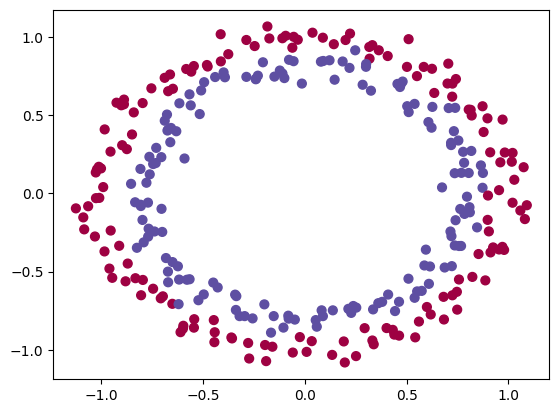

In [21]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [9]:
model = binary_classification_model('he_normal')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,611 (162.54 KB)

 Trainable params: 41,411 (161.76 KB)

 Non-trainable params: 200 (800.00 B)

## Training with Data collection
The explainer requires that we collect full data for the layer in question and those on either side.
So let's run a training sequence with detailed data collection.

We'll run for a few epochs so that we can pick an iteration that has some interesting characteristics. Also, for this very simple model, we don't have a good idea in advance which layer might lead to some interesting results, and it isn't very big, so we'll just collect all data across all layers.



In [10]:
# This will take a couple of minutes to run
reload(tot)
collection_sets = [{'include_non_trainable': True}]
variables = tot.VariableHistoryCallback(per_step=True, before_updates=True, collection_sets=collection_sets)
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=collection_sets)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=True, collection_sets=collection_sets)
activity = tot.ActivityHistoryCallback(per_step=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=20, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, output_gradients, activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Training via custom fit() function. Will produce a few warnings; you can usually ignore these.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_55']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_55']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


Epoch     2 - 4.35s/epoch: loss: 0.6673  
Epoch     4 - 1.91s/epoch: loss: 0.6662  
Epoch     6 - 1.26s/epoch: loss: 0.6679  
Epoch     8 - 1.27s/epoch: loss: 0.6496  
Epoch    10 - 1.27s/epoch: loss: 0.6565  
Epoch    12 - 1.07s/epoch: loss: 0.6519  
Epoch    14 - 1.12s/epoch: loss: 0.6476  
Epoch    16 - 2.18s/epoch: loss: 0.6359  
Epoch    18 - 778.62ms/epoch: loss: 0.6374  
Epoch    20 - 776.99ms/epoch: loss: 0.6201  
Total training time: 32.12 secs


Now let's take a look at the summary statistics and find a layer of interest and a point in time that's interesting.

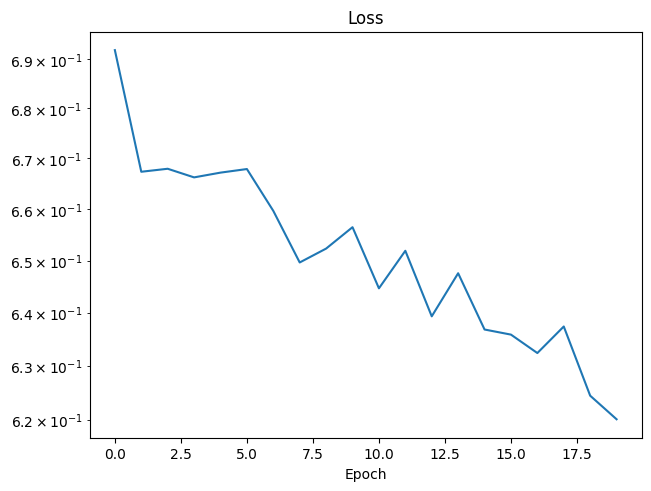

In [11]:
plot_fit(history)

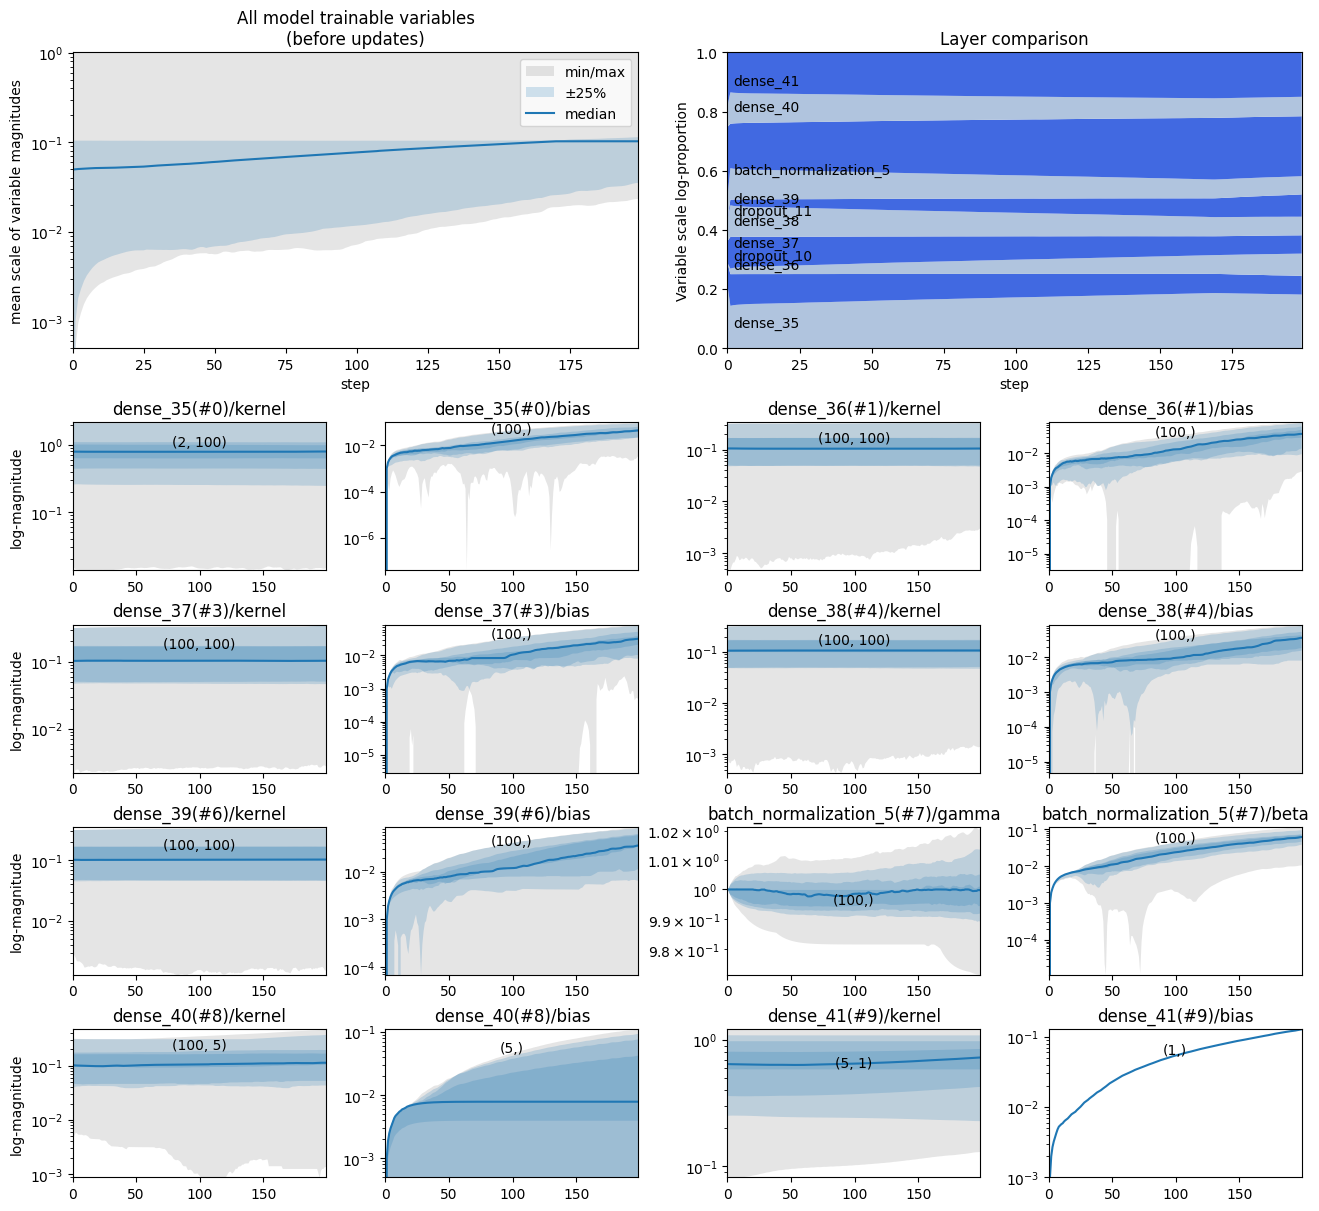

In [12]:
tot.plot_variable_history(variables, magnitudes=True)

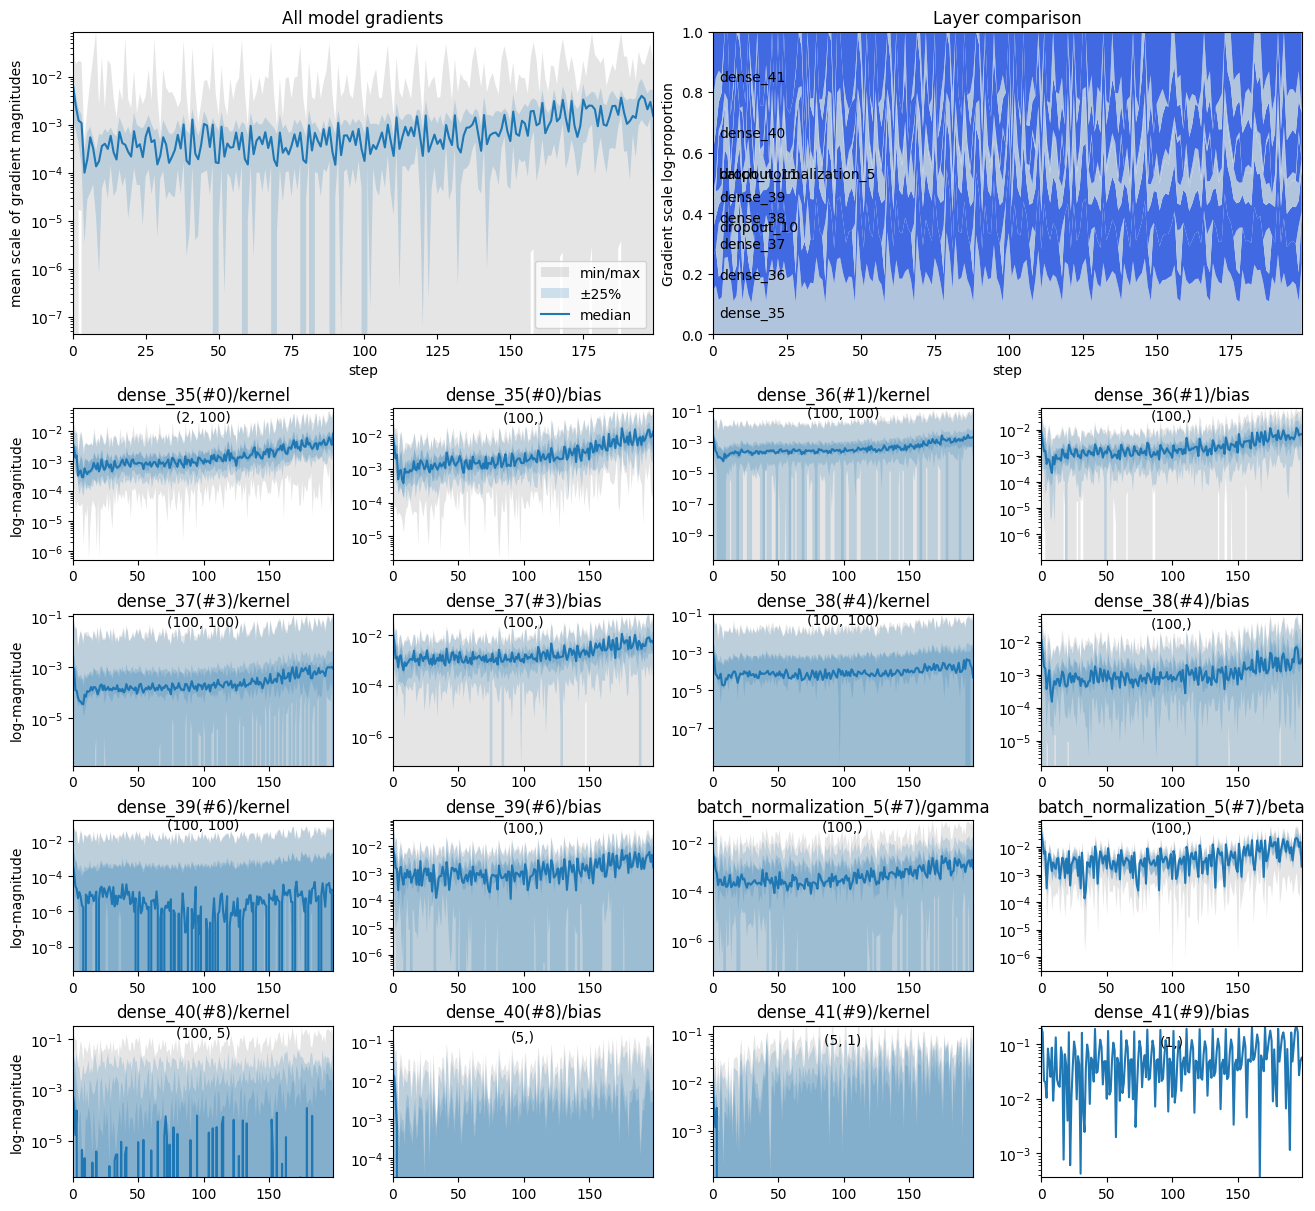

In [13]:
tot.plot_gradient_history(gradients, magnitudes=True)

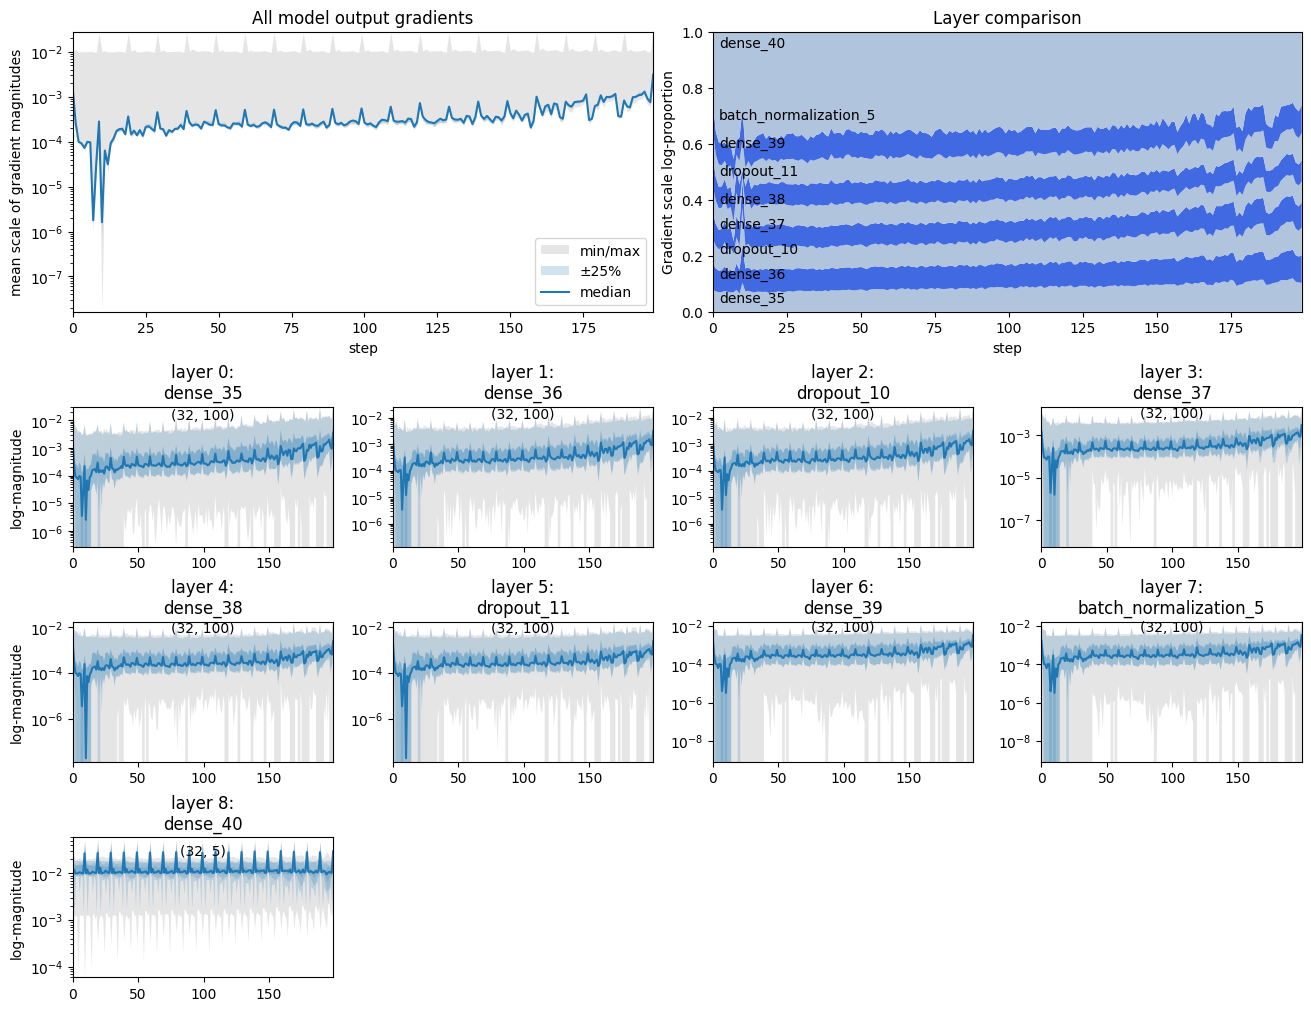

In [14]:
tot.plot_output_gradient_history(output_gradients, magnitudes=True)

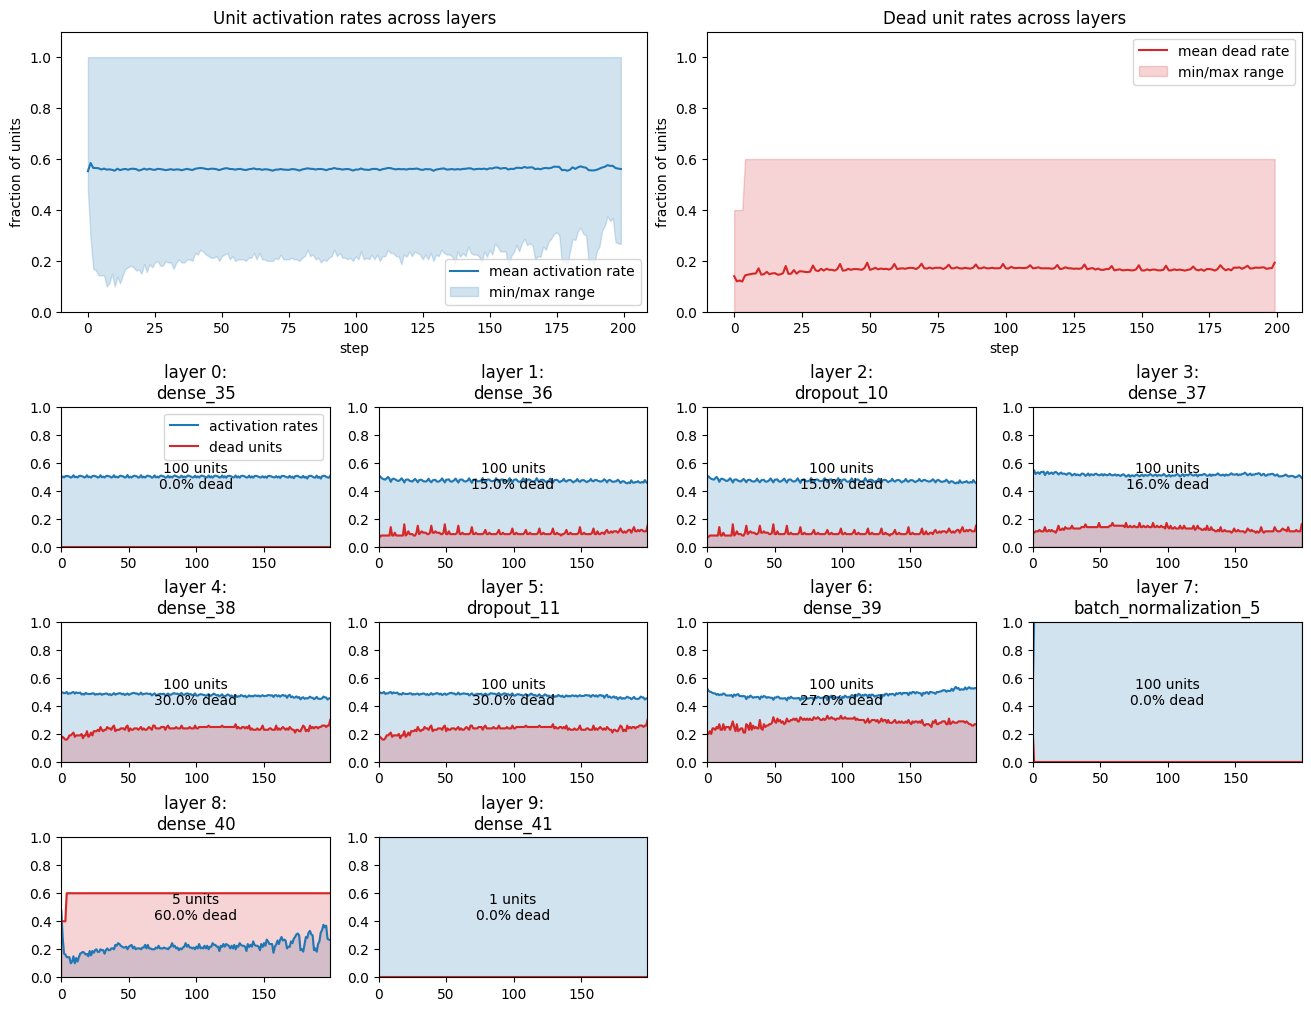

In [15]:
tot.plot_activity_rate_history(activity)

## Point of interest selection
From the above we can conclude that:
* This particular run didn't produce anything very exciting.
* The variable #6 (zero-based), the kernel of layer #4, experienced some zero gradients briefly during its first 200 iterations.

Let's narrow down on an iteration of interest.

In fact, as we'll see, the graphs above are not yet indicating the situation well enough. That variable actually has a large number of its individual values that stay at exactly zero throughout training.

In [17]:
selected_layer_idx = 3
selected_var_idx = 5
selected_iteration = 50
prev_layer_idx = 1
prev_var_idx = 2
next_layer_idx = 4
next_var_idx = 7

print(f"Previous layer: #{prev_layer_idx} = {model.layers[prev_layer_idx].name}, variable: #{prev_var_idx} = {model.variables[prev_var_idx].path}")
print(f"Target layer:   #{selected_layer_idx} = {model.layers[selected_layer_idx].name}, variable: #{selected_var_idx} = {model.variables[selected_var_idx].path}")
print(f"Next layer:     #{next_layer_idx} = {model.layers[next_layer_idx].name}, variable: #{next_var_idx} = {model.variables[next_var_idx].path}")

Previous layer: #1 = dense_36, variable: #2 = sequential_5/dense_36/kernel
Target layer:   #3 = dense_37, variable: #5 = sequential_5/dense_37/kernel
Next layer:     #4 = dense_38, variable: #7 = sequential_5/dense_38/kernel


In [18]:
gradients.gradient_stats[selected_var_idx]

0.0       12.5      25.0      37.5   50.0      62.5      75.0   \
0   -0.064000 -0.004469 -0.001017 -0.000013    0.0  0.000000  0.000965   
1   -0.046961 -0.003328 -0.000814 -0.000022    0.0  0.000000  0.000442   
2   -0.029660 -0.000873 -0.000104  0.000000    0.0  0.000000  0.000123   
3   -0.036899 -0.001222 -0.000117  0.000000    0.0  0.000000  0.000051   
4   -0.005640 -0.000407 -0.000062  0.000000    0.0  0.000000  0.000030   
..        ...       ...       ...       ...    ...       ...       ...   
195 -0.102891 -0.001408 -0.000056  0.000000    0.0  0.000119  0.000993   
196 -0.086983 -0.001469 -0.000173  0.000000    0.0  0.000054  0.000983   
197 -0.060821 -0.003708 -0.000950 -0.000044    0.0  0.000000  0.000266   
198 -0.080802 -0.004186 -0.001036 -0.000134    0.0  0.000000  0.000095   
199 -0.114518 -0.004499 -0.000872  0.000000    0.0  0.000000  0.000341   

        87.5      100.0  
0    0.004352  0.099813  
1    0.002645  0.064550  
2    0.000954  0.037815  
3    0.000667  0.033722  
4    0.000315  0.007188  
..        ...       ...  
195  0.004528  0.097906  
196  0.004279  0.089044  
197  0.001745  0.053525  
198  0.001541  0.087054  
199  0.003849  0.086039  

[200 rows x 9 columns]

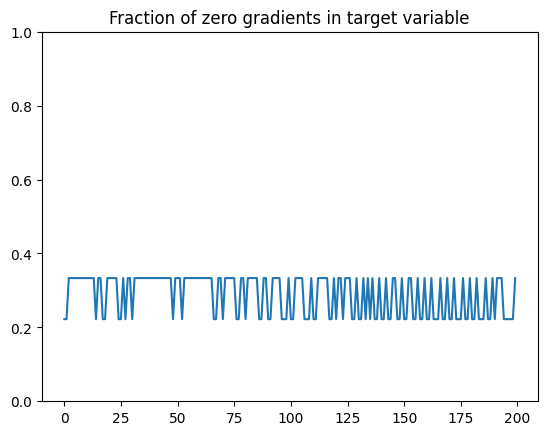

In [19]:
data = gradients.gradient_stats[selected_var_idx].to_numpy()
data = np.sum((data == 0.0), axis=-1) / data.shape[1]

plt.plot(data)
plt.title("Fraction of zero gradients in target variable")
plt.ylim([0.0, 1.0])
plt.show()

Let's take a closer look at the raw values at our selected iteration...

raw_weights:          (100, 100)
raw_activations:      (32, 100)
raw_gradients:        (100, 100)
raw_output_gradients: (32, 100)


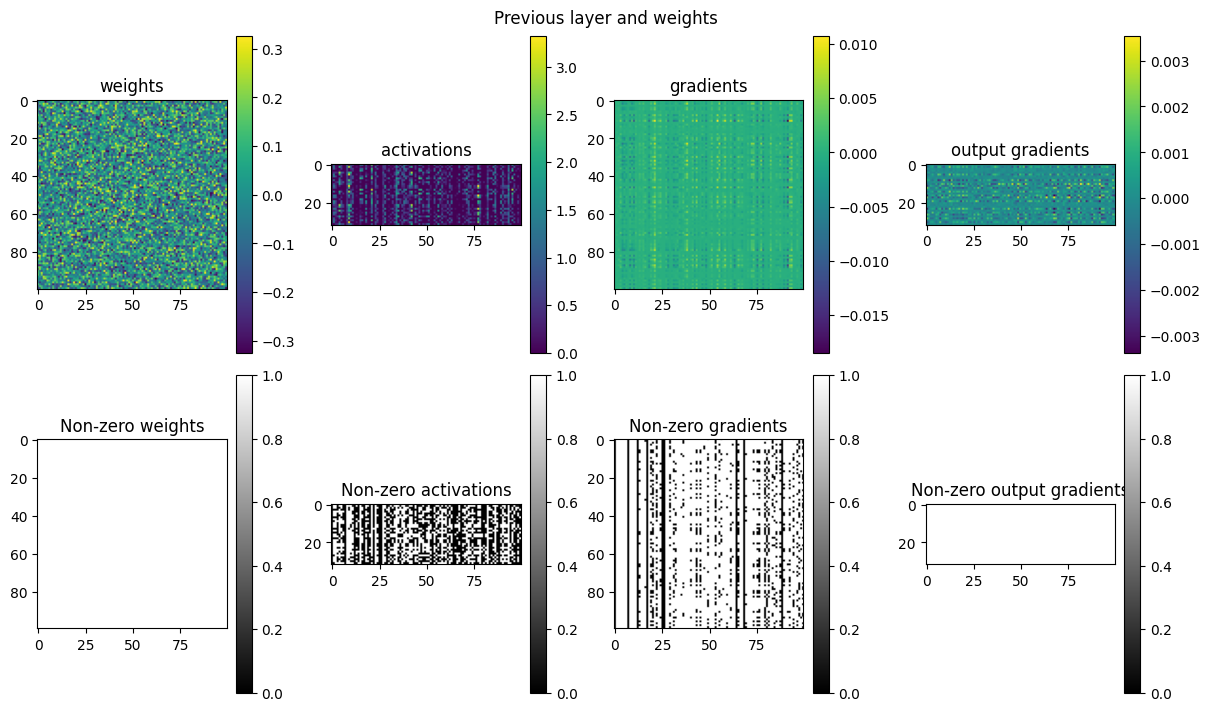

raw_weights:          (100, 100)
raw_activations:      (32, 100)
raw_gradients:        (100, 100)
raw_output_gradients: (32, 100)


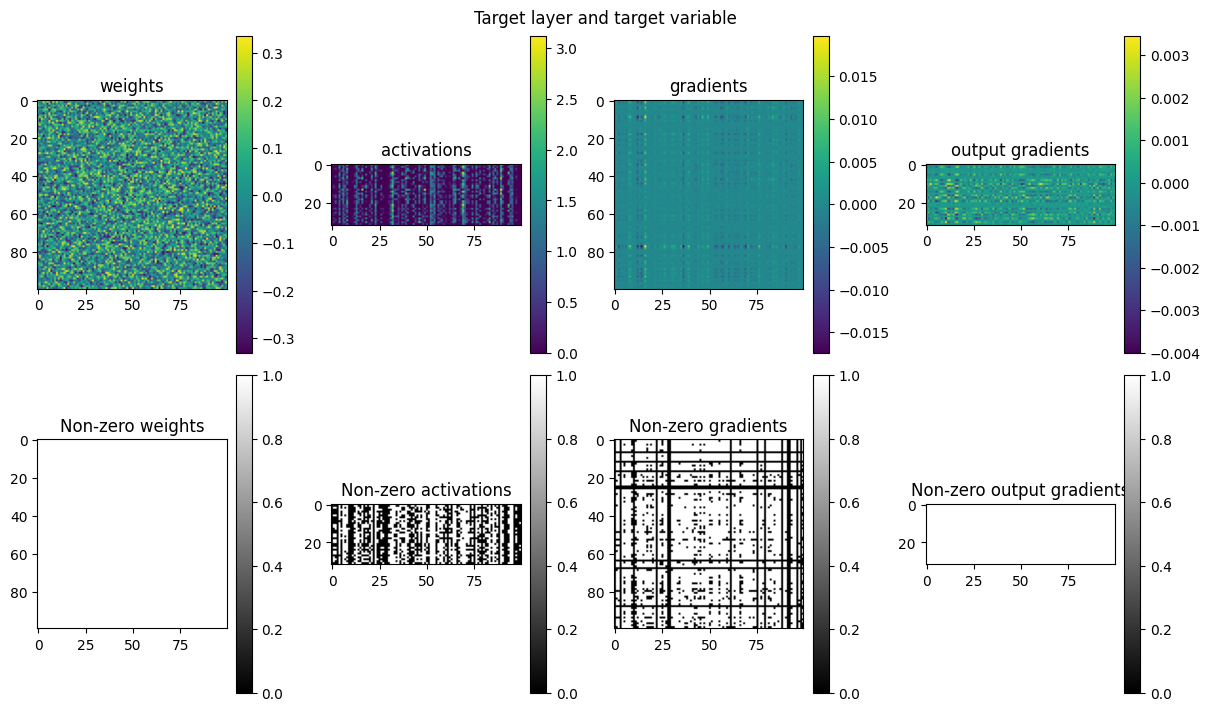

raw_weights:          (100, 100)
raw_activations:      (32, 100)
raw_gradients:        (100, 100)
raw_output_gradients: (32, 100)


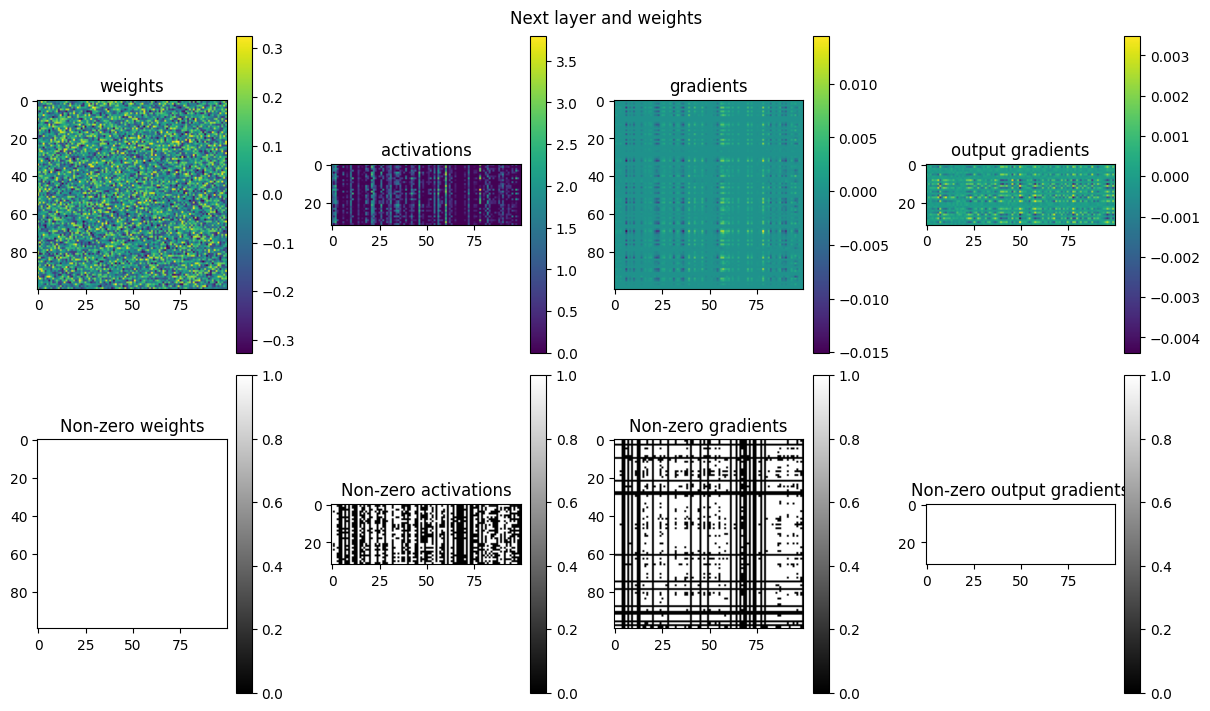

In [20]:
def plot_stuff(title, l_idx, var_idx, it_idx):
  raw_weights = variables.variables[var_idx][it_idx]
  raw_activations = activity.layer_outputs[l_idx][it_idx]
  raw_gradients = gradients.gradients[var_idx][it_idx]
  raw_output_gradients = output_gradients.gradients[l_idx][it_idx]
  print(f"raw_weights:          {raw_weights.shape}")
  print(f"raw_activations:      {raw_activations.shape}")
  print(f"raw_gradients:        {raw_gradients.shape}")
  print(f"raw_output_gradients: {raw_output_gradients.shape}")

  fig = plt.figure(figsize=(12,7), layout='constrained')
  fig.suptitle(title)

  plt.subplot(2,4,1)
  plt.title('weights')
  plt.imshow(raw_weights)
  plt.colorbar()

  plt.subplot(2,4,2)
  plt.title('activations')
  plt.imshow(raw_activations)
  plt.colorbar()

  plt.subplot(2,4,3)
  plt.title('gradients')
  plt.imshow(raw_gradients)
  plt.colorbar()

  plt.subplot(2,4,4)
  plt.title('output gradients')
  plt.imshow(raw_output_gradients)
  plt.colorbar()

  plt.subplot(2,4,5)
  plt.title('Non-zero weights')
  plt.imshow(raw_weights != 0, cmap='gray', vmin=0.0, vmax=1.0)
  plt.colorbar()

  plt.subplot(2,4,6)
  plt.title('Non-zero activations')
  plt.imshow(raw_activations != 0, cmap='gray', vmin=0, vmax=1.0)
  plt.colorbar()

  plt.subplot(2,4,7)
  plt.title('Non-zero gradients')
  plt.imshow(raw_gradients != 0, cmap='gray', vmin=0, vmax=1.0)
  plt.colorbar()

  plt.subplot(2,4,8)
  plt.title('Non-zero output gradients')
  plt.imshow(raw_output_gradients != 0, cmap='gray', vmin=0, vmax=1.0)
  plt.colorbar()

  plt.show()

plot_stuff("Previous layer and weights", prev_layer_idx, prev_var_idx, selected_iteration)
plot_stuff("Target layer and target variable", selected_layer_idx, selected_var_idx, selected_iteration)
plot_stuff("Next layer and weights", next_layer_idx, next_var_idx, selected_iteration)


## Explainer implementation

In [21]:
# First, check that we can get terse top-level explanations for near-zero values in tensors and tensor outcomes
grad = gradients.gradients[selected_var_idx][selected_iteration]
W_l = variables.variables[selected_var_idx][selected_iteration]
A_0 = activity.collected_layer_outputs[selected_layer_idx-1][selected_iteration]

print(f"gradients: {te.describe_tensor_near_zero_explanation(me.tensor_classify(grad), verbose=True)}")
print(f"weights:   {te.describe_tensor_near_zero_explanation(me.tensor_classify(W_l), negatives_are_bad=True, verbose=True)}")

print()
res = np.matmul(A_0, W_l)
desc, frac = te.describe_top_near_zero_explanandum(me.matmul_classify(A_0, W_l), input_names=['A_0', 'W_l'])
descriptions, fractions = te.describe_near_zero_explanation(me.matmul_classify(A_0, W_l), input_names=['A_0', 'W_l'])
print(f"Top explanation: {frac * 100:.1f}% due to {desc}")
print(f"All:")
for desc, frac in zip(descriptions, fractions):
  print(f"  {frac * 100:.1f}% due to {desc}")

gradients: 30.6% near-zero
weights:   50.7% negative, 5.0% near-zero

Top explanation: 52.2% due to near-zero values from A_0
All:
  52.2% due to near-zero values from A_0
  54.5% due to near-zero values from either input
  5.0% due to near-zero values from W_l
  2.3% due to positive/negatives from W_l cancelling out (PP ~= PN)
  2.3% due to sums of positive/negatives from both inputs cancelling out (PP+NN ~= NP+PN)


In [69]:
# And now, a full-blown explanation
explain_near_zero_gradients([variables, activity, gradients, output_gradients], selected_layer_idx, step=selected_iteration, verbose=True)

layer: #3 = <Dense name=dense_37, built=True> at iteration 50
  inbound_layer_indices: [2]
  outbound_layer_indices: [4]

Summary...
  near-zero gradients: 3058 (30.6%) = 0

Let:
  A_0 <- input activation to target layer
  W_l <- weights of target layer
  Z_l <- pre-activation output of target layer
  S_l <- effect of activation function as element-wise multiplier
  A_l <- output activation of target layer
  PZN <- breakdown of values into (P)ositive, near-(Z)ero, or (N)egative

Forward pass...
A_0 - input value:
  shape:             (32, 100) -> total values: 3200
  summary:           52.2% near-zero (= 0), 9.0% of units always near-zero across all batch dims
  value percentiles: [0, 25, 50, 75, 100] -> [0.        0.        0.        0.5432665 3.325561 ]
  PZN counts/sums:   Z: 1670.0 = Σ 0, P: 1530.0 = Σ 1081
  PZN counts/means:  Z: 52.2% x 0.000000, P: 47.8% x 0.706359
W_l - weights of target layer:
  shape:             (100, 100) -> total values: 10000
  summary:           1.0% nea

## CNN Model

In [22]:
def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
train_X: (60000, 28, 28), train_Y: (60000,)


In [23]:
mnist_cnn_model().summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,570 (619.41 KB)

 Trainable params: 158,570 (619.41 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Model training
reload(tot)
per_step=True
collection_sets = [{'include_non_trainable': True, 'layer_indices': [1, 2, 4, 5]}]
variables = tot.VariableHistoryCallback(per_step=per_step, before_updates=True, collection_sets=collection_sets)
gradients = tot.GradientHistoryCallback(per_step=per_step, collection_sets=collection_sets)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=per_step, collection_sets=collection_sets)
activity = tot.ActivityHistoryCallback(per_step=per_step, collection_sets=collection_sets)

model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).take(3200).batch(32)

start = tf.timestamp()
history = tot.fit(model, dataset, epochs=2, callbacks=[variables, gradients, output_gradients, activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Training via custom fit() function. Will produce a few warnings; you can usually ignore these.
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_277']
Received: inputs=Tensor(shape=(32, 28, 28))
  warnings.warn(msg)


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.5456 - loss: 0.8733
Epoch 2/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8939 - loss: 0.2960
Total training time: 14.93 secs


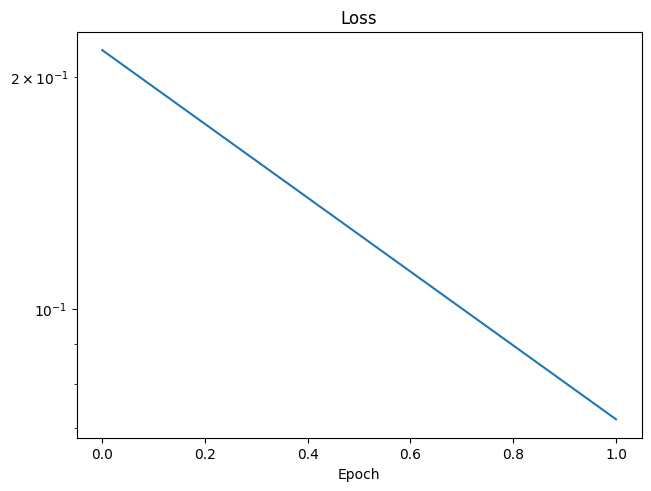

In [25]:
plot_fit(history)

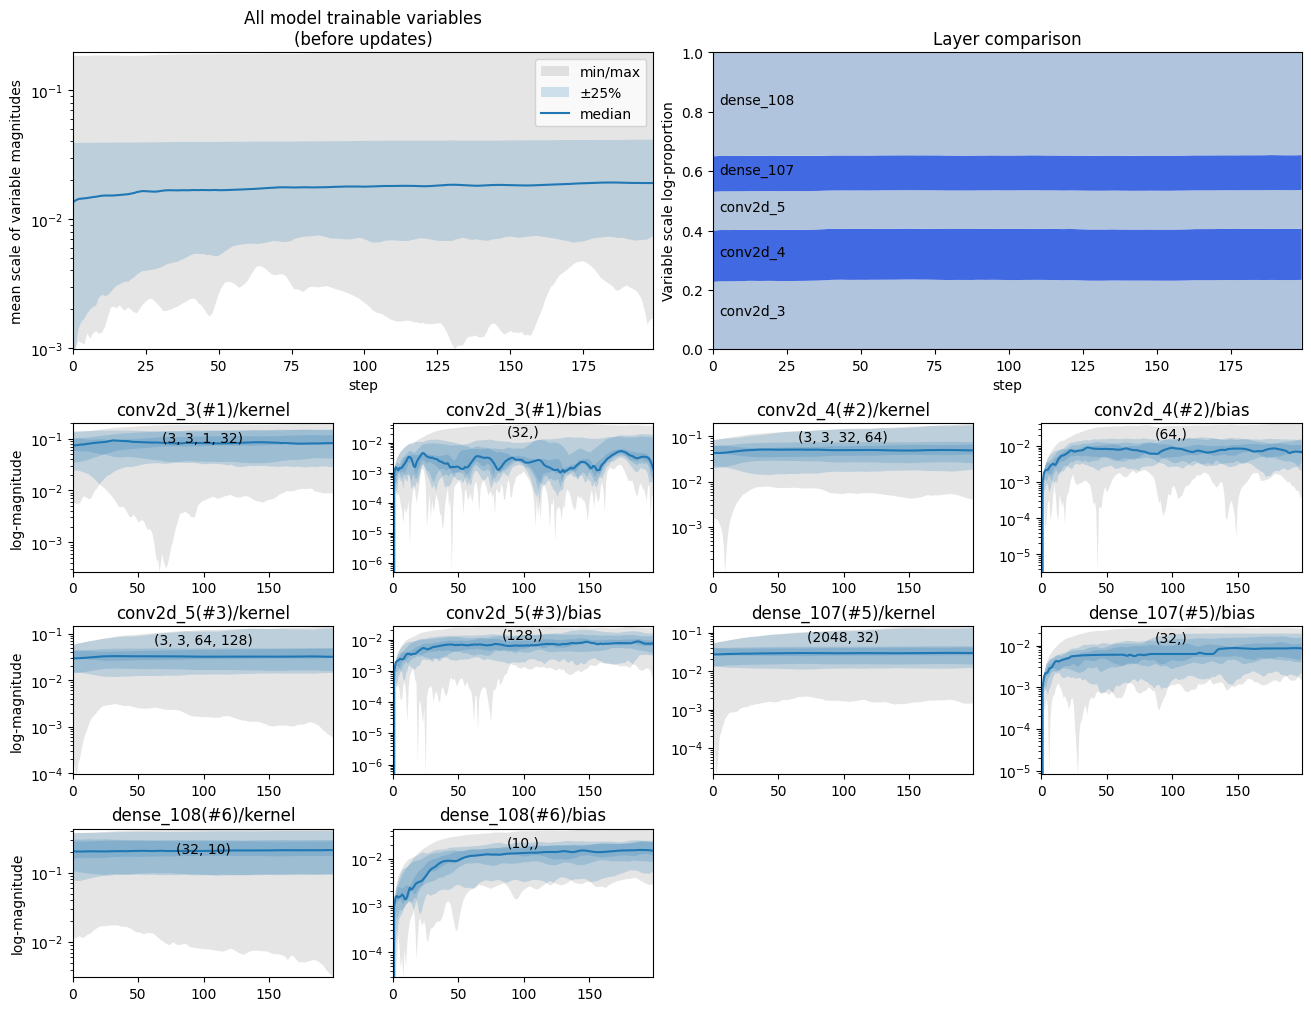

In [27]:
tot.plot_variable_history(variables, magnitudes=True)

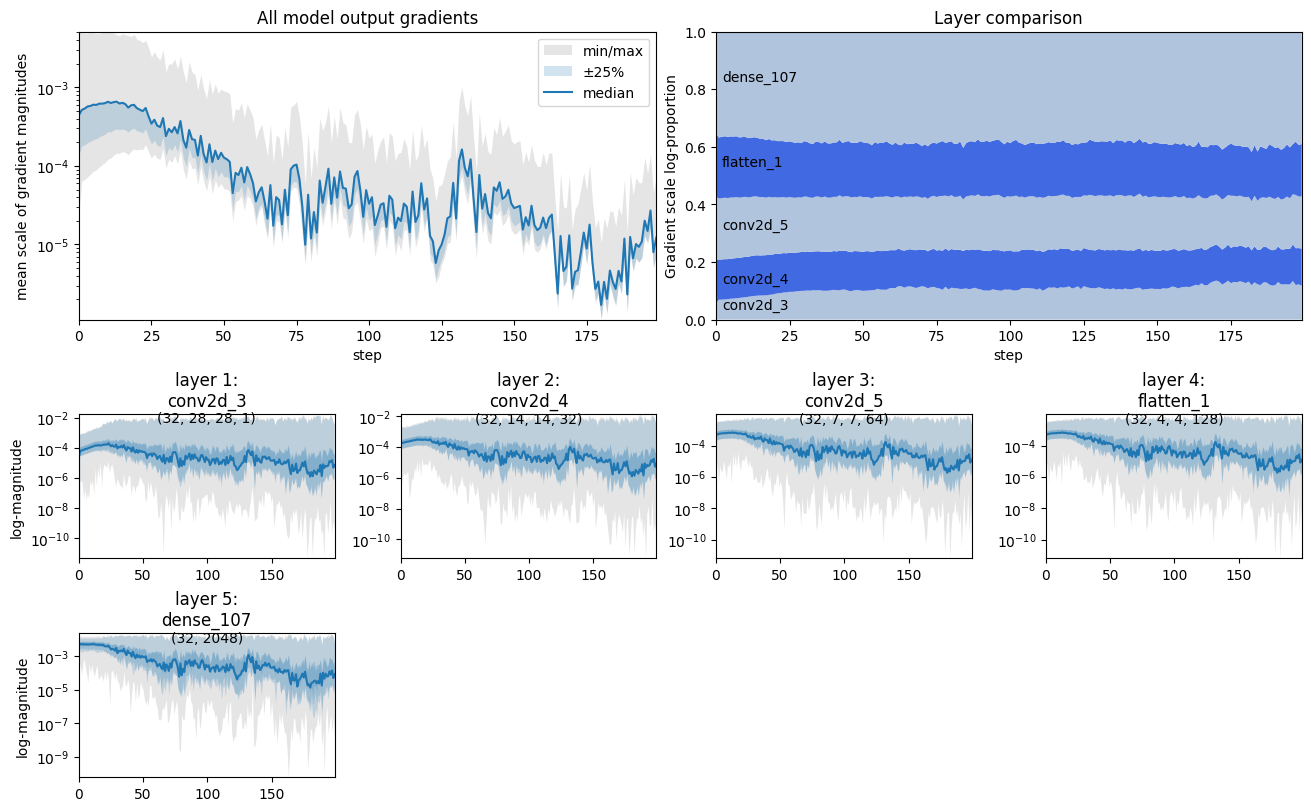

In [28]:
tot.plot_output_gradient_history(output_gradients, magnitudes=True)

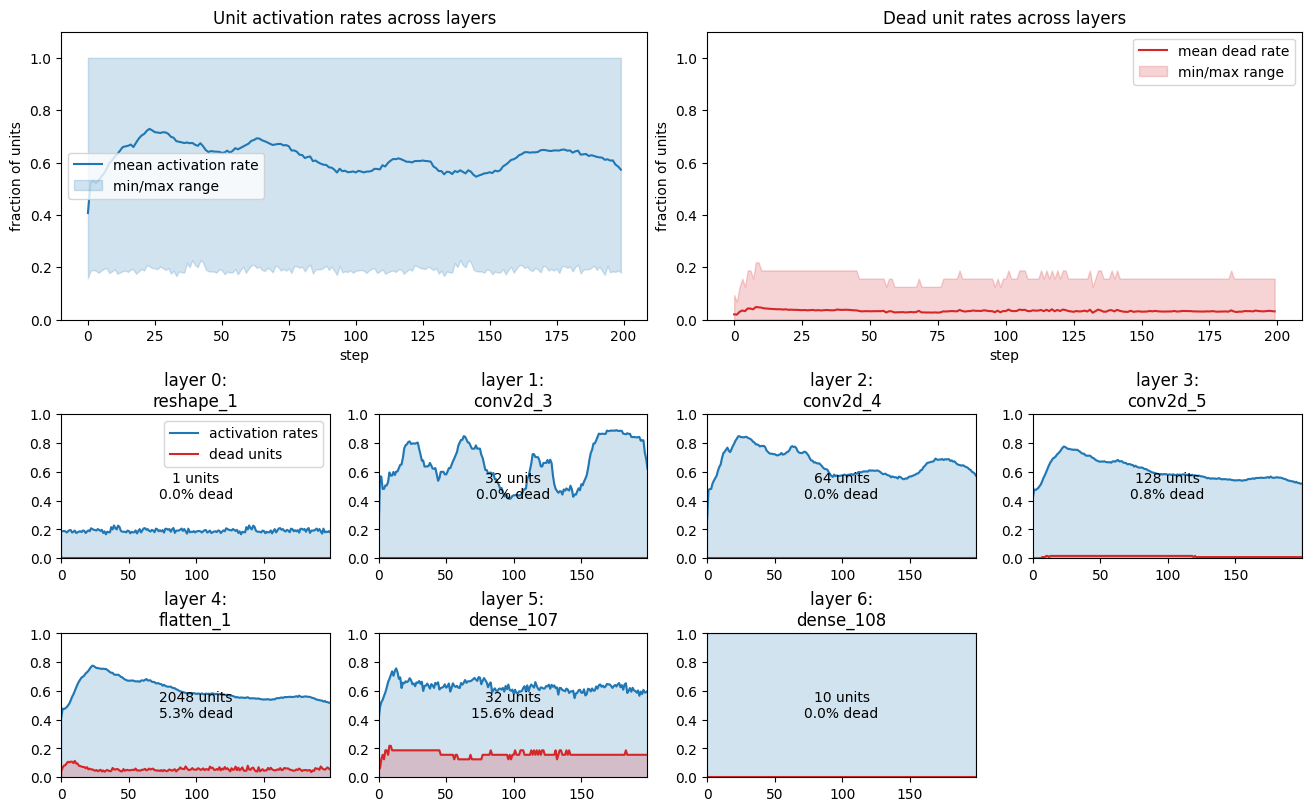

In [29]:
tot.plot_activity_rate_history(activity)

In [103]:
reload(te)
selected_layer_idx = 5
selected_iteration = 50
te.explain_near_zero_gradients([variables, activity, gradients, output_gradients], selected_layer_idx, step=selected_iteration, verbose=False)

layer: #5 = <Dense name=dense_167, built=True> at iteration 50
  inbound_layer_indices: [4]
  outbound_layer_indices: [6]

Summary...
  near-zero gradients: 14465 (22.1%) = 0

Let:
  A_0 <- input activation to target layer
  W_l <- weights of target layer
  Z_l <- pre-activation output of target layer
  S_l <- effect of activation function as element-wise multiplier
  A_l <- output activation of target layer

Forward pass...
A_0 - input value:
  shape:             (32, 2048) -> total values: 65536
  summary:           32.0% near-zero, 3.5% of units always near-zero across all batch dims
W_l - weights of target layer:
  shape:             (2048, 32) -> total values: 65536
  summary:           1.0% near-zero
  corresponding to near-zero gradients: 1.2% near-zero
compute Z_l = A_0 . W_l + b_l:
  inputs examined:   A_0, W_l
  summary:           1.1% near-zero
Z_l - pre-activation output:
  shape:             (32, 32) -> total values: 1024
  summary:           35.4% negative, 18.8% of units

In [101]:
reload(te)
l_idx = 5  # 2=conv layer, 5=dense layer
var_indices = tot.variable_indices_by_layer(model)[l_idx]
print(f"layer: {model.layers[l_idx]}")
print(f"variable_indices: {var_indices}")
print(f"output:           {activity.layer_outputs[l_idx][50].shape}")

handler = te.DenseLayerHandler(
    display_name=f"layer_{l_idx}",
    variables = [variables.variables[v_idx][50] for v_idx in var_indices],
    gradients = [gradients.gradients[v_idx][50] for v_idx in var_indices],
    inputs = [activity.layer_outputs[l_idx-1][50]],
    output = activity.layer_outputs[l_idx][50],
    output_gradients = output_gradients.gradients[l_idx][50],
    layer_subscript='l')

print(f"A_l: {handler.get_A().shape}")
print(f"Z: {handler.calculate_Z().shape}")
dJdA = handler.output_gradients
dJdZ = handler.calculate_dJdZ(dJdA)
print(f"dJdW: {handler.calculate_dJdW(dJdZ).shape}")

layer: <Dense name=dense_167, built=True>
variable_indices: [6, 7]
output:           (32, 32)
A_l: (32, 32)
Z: (32, 32)
dJdW: (2048, 32)


In [107]:
model.layers[2].padding

'same'

In [97]:
if tf.rank(dJdZ) > 1:
  print("yes")

yes


In [68]:
tf.random.set_seed(36)
a = tf.random.normal((32, 51, 31, 5))  # b*h*w*ch
k = tf.random.normal((5, 6))  # in*out
r = np.tensordot(a, k, axes=[[-1], [0]])
print(f"a: {a.shape}, k: {k.shape}, r: {r.shape}")

a = tf.random.normal((32, 5))  # b*units
k = tf.random.normal((5, 6))  # in*out
r = np.tensordot(a, k, axes=[[-1], [0]])
print(f"a: {a.shape}, k: {k.shape}, r: {r.shape}")

a: (32, 51, 31, 5), k: (5, 6), r: (32, 51, 31, 6)
a: (32, 5), k: (5, 6), r: (32, 6)


In [64]:
A_0 = tf.random.normal((4, 3, 5))  # Shape (batch=4, unflattened_dim=3, units_in=5)
W = tf.random.normal((5, 2))       # Shape (units_in=5, units_out=2)
bias = tf.random.normal((2,))      # Shape (units_out=2)
output = tf.tensordot(A_0, W, axes=([-1], [0]))
print(f"A_0: {A_0.shape}, W: {W.shape}, output: {output.shape}")

A_0: (4, 3, 5), W: (5, 2), output: (4, 3, 2)


In [69]:
A_0 = tf.random.normal((4, 5, 6, 7))  # (batch=4, height=5, width=6, units_in=7)
dJdZ = tf.random.normal((4, 5, 6, 10))  # (batch=4, height=5, width=6, units_out=10)
dJdW = tf.tensordot(A_0, dJdZ, axes=[list(range(len(A_0.shape) - 1)), list(range(len(dJdZ.shape) - 1))])
print(f"A_0: {A_0.shape}, dJdZ: {dJdZ.shape}, dJdW: {dJdW.shape}")

A_0: (4, 5, 6, 7), dJdZ: (4, 5, 6, 10), dJdW: (7, 10)


In [113]:
def my_func(a, b, c=None, d=None, e=5):
  print(f"{a=}, {b=}, {c=}, {d=}, {e=}")

blag = {
    'c': ['one', 'two'],
    'd': 3
}

my_func(5,6, e=10, **blag)

a=5, b=6, c=['one', 'two'], d=3, e=10


In [44]:
gradients.model_stats

## Appendix: Proving out layer handler calculations

In [123]:
reload(te)
l_idx = 5  # 2=conv layer, 5=dense layer
var_indices = tot.variable_indices_by_layer(model)[l_idx]
print(f"layer: {model.layers[l_idx]}")
print(f"variable_indices: {var_indices}")
print(f"output:           {activity.layer_outputs[l_idx][50].shape}")

handler = te.DenseLayerHandler(
    display_name=f"layer_{l_idx}",
    layer = model.layers[l_idx],
    variables = [variables.variables[v_idx][50] for v_idx in var_indices],
    gradients = [gradients.gradients[v_idx][50] for v_idx in var_indices],
    inputs = [activity.layer_outputs[l_idx-1][50]],
    output = activity.layer_outputs[l_idx][50],
    output_gradients = output_gradients.gradients[l_idx][50],
    layer_subscript='l')

print(f"A_0: {handler.get_input().shape}")
print(f"W_l: {handler.get_weights().shape}")
print(f"b_l: {handler.get_biases_or_none().shape}")
print(f"A_l: {handler.get_A().shape}")
print(f"Z: {handler.calculate_Z().shape}")
dJdA = handler.output_gradients
dJdZ = handler.calculate_dJdZ(dJdA)
print(f"dJdW: {handler.calculate_dJdW(dJdZ).shape}")

layer: <Dense name=dense_167, built=True>
variable_indices: [6, 7]
output:           (32, 32)
A_0: (32, 2048)
W_l: (2048, 32)
b_l: (32,)
A_l: (32, 32)
Z: (32, 32)
dJdW: (2048, 32)


In [126]:
reload(te)
l_idx = 2  # 2=conv layer, 5=dense layer
var_indices = tot.variable_indices_by_layer(model)[l_idx]
print(f"layer: {model.layers[l_idx]}")
print(f"variable_indices: {var_indices}")
print(f"output:           {activity.layer_outputs[l_idx][50].shape}")

handler = te.ConvLayerHandler(
    display_name=f"layer_{l_idx}",
    layer = model.layers[l_idx],
    variables = [variables.variables[v_idx][50] for v_idx in var_indices],
    gradients = [gradients.gradients[v_idx][50] for v_idx in var_indices],
    inputs = [activity.layer_outputs[l_idx-1][50]],
    output = activity.layer_outputs[l_idx][50],
    output_gradients = output_gradients.gradients[l_idx][50],
    layer_subscript='l')

print(f"A_0: {handler.get_input().shape}")
print(f"W_l: {handler.get_weights().shape}")
print(f"b_l: {handler.get_biases_or_none().shape}")
print(f"A_l: {handler.get_A().shape}")
print(f"Z: {handler.calculate_Z().shape}")
dJdA = handler.output_gradients
dJdZ = handler.calculate_dJdZ(dJdA)
print(f"dJdA: {dJdA.shape}")
print(f"dJdZ: {dJdZ.shape} -- calculated")
print(f"dJdW: {handler.output_gradients.shape}")
print(f"dJdW: {handler.calculate_dJdW(dJdZ).shape} -- calculated")

layer: <Conv2D name=conv2d_10, built=True>
variable_indices: [2, 3]
output:           (32, 7, 7, 64)
A_0: (32, 14, 14, 32)
W_l: (3, 3, 32, 64)
b_l: (64,)
A_l: (32, 7, 7, 64)
Z: (32, 7, 7, 64)
dJdA: (32, 7, 7, 64) -- actual
dJdZ: (32, 7, 7, 64) -- calculated
dJdW: (32, 7, 7, 64) -- actual


InvalidArgumentError: {{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} Conv2DSlowBackpropInput: input and out_backprop must have the same batch size. Input batch: 3, outbackprop batch: 32, batch_dim: 0 [Op:Conv2DBackpropInput]

In [132]:
# Example usage
A_0 = tf.random.normal((4, 8, 8, 3))  # (batch=4, height=8, width=8, channels_in=3)
W_shape = (3, 3, 3, 16)  # (filter_height=3, filter_width=3, in_channels=3, out_channels=16)
dJdZ = tf.random.normal((4, 8, 8, 16))  # (batch=4, height=8, width=8, channels_out=16)

# Compute dJ/dW
dJdW = tf.conv2d_backprop_filter_v2(
    input=A_0,
    filter=W,
    out_backprop=dJdZ,
    strides=[1, 1],
    padding='SAME'
)

print("A_0 shape:", A_0.shape)
print("dJdZ shape:", dJdZ.shape)
print("Computed dJ/dW shape:", dJdW.shape)  # Should match W_shape



NotFoundError: Could not find device for node: {{node Conv2DBackpropFilterV2}} = Conv2DBackpropFilterV2[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="SAME", strides=[1, 1], use_cudnn_on_gpu=true]
All kernels registered for op Conv2DBackpropFilterV2:
  <no registered kernels>
 [Op:Conv2DBackpropFilterV2] name: 

## Appendix: Proving out how to calculate the backprop of a conv later

In [225]:
# from: https://stackoverflow.com/questions/39373230/what-does-tensorflows-conv2d-transpose-operation-do/44350789#44350789
# and:  https://gist.github.com/yxlao/ef50416011b9587835ac752aa3ce3530
# also see: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md  <-- need to add this to my docs
def tf_rot180(w):
    """
    Roate by 180 degrees
    """
    return tf.reverse(w, axis=[0, 1])

def tf_pad_to_full_conv2d(x, w_size):
    """
    Pad x, such that using a 'VALID' convolution in tensorflow is the same
    as using a 'FULL' convolution. See
    http://deeplearning.net/software/theano/library/tensor/nnet/conv.html#theano.tensor.nnet.conv2d
    for description of 'FULL' convolution.
    """
    return tf.pad(x, [[0, 0],
                      [w_size - 1, w_size - 1],
                      [w_size - 1, w_size - 1],
                      [0, 0]])

def tf_NHWC_to_HWIO(out):
    """
    Converts [batch, in_height, in_width, in_channels]
    to       [filter_height, filter_width, in_channels, out_channels]
    """
    return tf.transpose(out, perm=[1, 2, 0, 3])

def tf_NHWC_to_CHWN(out):
    """
    Converts [batch, in_height, in_width, in_channels]
    to       [in_channels, in_height, in_width, batch]
    """
    return tf.transpose(out, perm=[3, 1, 2, 0])

#d_w_manual = tf_NHWC_to_HWIO(tf.nn.conv2d(input=x,
#                                          filter=tf_NHWC_to_HWIO(d_out),
#                                          strides=strides,
#                                          padding='VALID'))

A_0 = tf.random.normal((32, 8, 8, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
#dJdZ = tf.random.normal((32, 6, 6, 16))  # (batch=32, height=8, width=8, channels_out=16)
expected_Z = tf.random.normal((32, 6, 6, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=[1, 1], padding='VALID')
  # compute mse loss against expected_Z
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")


# Compute dJ/dW - original
# - error: input depth must be evenly divisible by filter depth: 5 vs 32
#dJdW = tf_NHWC_to_HWIO(tf.nn.conv2d(
#    input=A_0,
#    filters=tf_NHWC_to_HWIO(dJdZ),
#    strides=[1, 1],
#    padding='VALID'))

# - error: input depth must be evenly divisible by filter depth: 5 vs 6
#dJdW = tf.nn.conv2d(
#    input=A_0,
#    filters=dJdZ,
#    strides=[1, 1],
#    padding='VALID')

# prove that a normal looking conv2d_transpose works
# emulates dJdA_0 - backprop w.r.t. input
filters = tf.random.normal((3, 3, 5, 16))
fun = tf.nn.conv2d_transpose(
    input=dJdZ,                  # (32, 6, 6, 16),  where 6 = 8 - (3-1), 6 = 8 - (3-1)
    filters=filters,             # (3, 3, 5, 16)
    output_shape=(32, 8, 8, 5),  # (32, 8, 8, 5)
    strides=[1, 1],
    padding='VALID')             # out: (32, 8, 8, 5)
print(f"fun: {fun.shape}")

# emulating dJdA_0 - backprop w.r.t. input
#dJdW = tf.nn.conv2d_transpose(
#    input=tf.random.normal(  (32, 1, 2, 7)),
#    filters=tf.random.normal((3, 3, 5, 7)),
#    output_shape=            (32, 3, 4, 5),    # want (3, 3, 5, 7)
#    strides=[1, 1],
#    padding='VALID')
#print(f"dJdW: {dJdW.shape}")

# emulating dJdA_0 - backprop w.r.t. input (simple VALID padding, and 1x1 strides)
dJdW = tf.nn.conv2d(
    input=tf.random.normal(  (5, 16, 16, 32)),   # NHWC_to_CHWN(A_0)
    filters=tf.random.normal((14, 14, 32, 7)),   # NHWC_to_HWIO(dJdZ)
    strides=[1, 1],
    padding='VALID')
print(f"dJdW: {dJdW.shape}")  # (5, 3, 3, 7)

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(A_0),       # (5, 8, 8, 32) <- (32, 8, 8, 5)
    filters=tf_NHWC_to_HWIO(dJdZ),    # (6, 6, 32, 16) <- (32, 6, 6, 16)
    strides=[1, 1],
    padding='VALID')                  # (5, 3, 3, 16)   -> (3, 3, 5, 16)
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")

true: dJdZ: (32, 6, 6, 16), dJdW: (3, 3, 5, 16)
fun: (32, 8, 8, 5)
dJdW: (5, 3, 3, 7)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-5.9604645e-08 -7.4505806e-09  0.0000000e+00  7.4505806e-09
  7.4505806e-08], same: True


In [206]:
print(f"dJdZ: {dJdZ.shape}, padded: {tf_pad_to_full_conv2d(dJdZ, 2).shape}")

dJdZ: (32, 8, 8, 16), padded: (32, 10, 10, 16)


In [209]:
# for padding=SAME, pad A_0
padding='SAME'
strides=[1, 1]

A_0 = tf.random.normal((32, 8, 8, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 8, 8, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 2)),
    filters=tf_NHWC_to_HWIO(dJdZ),
    strides=strides, padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")


true: dJdZ: (32, 8, 8, 16), dJdW: (3, 3, 5, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-5.9604645e-08 -7.4505806e-09  0.0000000e+00  5.5879354e-09
  5.9604645e-08], same: True


In [267]:
# Padding VALID plus strides: dilate dJdZ with one-sided padding on RIGHT
padding='VALID'
strides=[2, 2]

def insert_zeros(tensor, stride, extra_pad=None):
    """
    Inserts zeros between pixels in the height and width dimensions to simulate fractional strides.

    Args:
        tensor: A 4D tensor (NHWC) with shape (batch, height, width, channels)
        stride: Stride size (integer) - the number of zeros to insert between pixels.

    Returns:
        A new tensor with zeros inserted in the height and width dimensions.
    """
    batch, height, width, channels = tensor.shape

    # Create empty tensor with expanded shape (height + gaps, width + gaps)
    new_height = height + (height - 1) * (stride - 1)
    new_width = width + (width - 1) * (stride - 1)

    # Create a tensor of zeros
    new_tensor = tf.zeros((batch, new_height, new_width, channels), dtype=tensor.dtype)

    # Assign original values to non-zero positions
    new_tensor = tf.tensor_scatter_nd_update(
        new_tensor,
        indices=tf.reshape(
            tf.stack(tf.meshgrid(
                tf.range(batch),
                tf.range(0, new_height, stride),
                tf.range(0, new_width, stride),
                indexing='ij'
            ), axis=-1),
            shape=(-1, 3)  # Flatten the indices
        ),
        updates=tf.reshape(tensor, [-1, channels])
    )
    if stride > 1 and extra_pad is not None:
      l = extra_pad[0]
      r = extra_pad[1]
      new_tensor = tf.pad(new_tensor, [[0, 0],
                        [l, r],
                        [l, r],
                        [0, 0]])

    return new_tensor


A_0 = tf.random.normal((32, 16, 16, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 7, 7, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  print(f"Z: {Z.shape}")
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

print(f"dJdZ: {dJdZ.shape}, with strides: {insert_zeros(dJdZ, 2).shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 1)),  # increase to make kernel bigger
    filters=tf_NHWC_to_HWIO(insert_zeros(dJdZ, 2, [0, 1])),
    strides=[1, 1], padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")


Z: (32, 7, 7, 16)
true: dJdZ: (32, 7, 7, 16), dJdW: (3, 3, 5, 16)
dJdZ: (32, 7, 7, 16), with strides: (32, 13, 13, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-1.4901161e-07 -7.4505806e-09  0.0000000e+00  7.4505806e-09
  8.9406967e-08], same: False


In [271]:
# Padding SAME plus strides: pad A_0, dilate dJdZ with one-sided padding on LEFT
padding='SAME'
strides=[2, 2]

A_0 = tf.random.normal((32, 16, 16, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 8, 8, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  print(f"Z: {Z.shape}")
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

print(f"dJdZ: {dJdZ.shape}, with strides: {insert_zeros(dJdZ, 2).shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 2)),  # increase to make kernel bigger
    filters=tf_NHWC_to_HWIO(insert_zeros(dJdZ, 2, [1, 0])),
    strides=[1, 1], padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")


Z: (32, 8, 8, 16)
true: dJdZ: (32, 8, 8, 16), dJdW: (3, 3, 5, 16)
dJdZ: (32, 8, 8, 16), with strides: (32, 15, 15, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-5.9604645e-08 -7.4505806e-09  0.0000000e+00  7.4505806e-09
  5.9604645e-08], same: True


In [274]:
# Odd-sized inputs, padding=VALID: do nothing extra (same as for even sized inputs)
padding='VALID'
strides=[1, 1]

A_0 = tf.random.normal((32, 9, 9, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 7, 7, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 1)),
    filters=tf_NHWC_to_HWIO(dJdZ),
    strides=strides, padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")

true: dJdZ: (32, 7, 7, 16), dJdW: (3, 3, 5, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-8.940697e-08 -7.450581e-09  0.000000e+00  7.450581e-09  8.940697e-08], same: True


In [275]:
# Odd-sized inputs, padding=SAME: pad A_0 and nothing extra (same as for even sized inputs)
padding='SAME'
strides=[1, 1]

A_0 = tf.random.normal((32, 9, 9, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 9, 9, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 2)),
    filters=tf_NHWC_to_HWIO(dJdZ),
    strides=strides, padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")

true: dJdZ: (32, 9, 9, 16), dJdW: (3, 3, 5, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-5.9604645e-08 -7.4505806e-09  0.0000000e+00  5.5879354e-09
  5.9604645e-08], same: True


In [279]:
# Odd-sized inputs, padding VALID plus strides: dilate dJdZ without one-sided padding
padding='VALID'
strides=[2, 2]

A_0 = tf.random.normal((32, 17, 17, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 8, 8, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  print(f"Z: {Z.shape}")
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

print(f"dJdZ: {dJdZ.shape}, with strides: {insert_zeros(dJdZ, 2, [0, 0]).shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 1)),  # increase to make kernel bigger
    filters=tf_NHWC_to_HWIO(insert_zeros(dJdZ, 2, [0, 0])),
    strides=[1, 1], padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")


Z: (32, 8, 8, 16)
true: dJdZ: (32, 8, 8, 16), dJdW: (3, 3, 5, 16)
dJdZ: (32, 8, 8, 16), with strides: (32, 16, 16, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-8.9406967e-08 -7.4505806e-09  0.0000000e+00  7.4505806e-09
  5.9604645e-08], same: True


In [282]:
# Odd-sized inputs, padding SAME plus strides: pad A_0, dilate dJdZ without one-sided padding
padding='SAME'
strides=[2, 2]

A_0 = tf.random.normal((32, 17, 17, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 9, 9, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  print(f"Z: {Z.shape}")
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

print(f"dJdZ: {dJdZ.shape}, with strides: {insert_zeros(dJdZ, 2).shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 2)),  # increase to make kernel bigger
    filters=tf_NHWC_to_HWIO(insert_zeros(dJdZ, 2, [0, 0])),
    strides=[1, 1], padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")


Z: (32, 9, 9, 16)
true: dJdZ: (32, 9, 9, 16), dJdW: (3, 3, 5, 16)
dJdZ: (32, 9, 9, 16), with strides: (32, 17, 17, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-5.9604645e-08 -4.4237822e-09  0.0000000e+00  7.4505806e-09
  5.9604645e-08], same: True


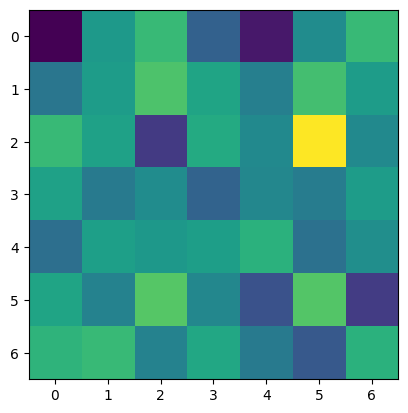

In [254]:
plt.imshow(dJdZ[0, :, :, 0])

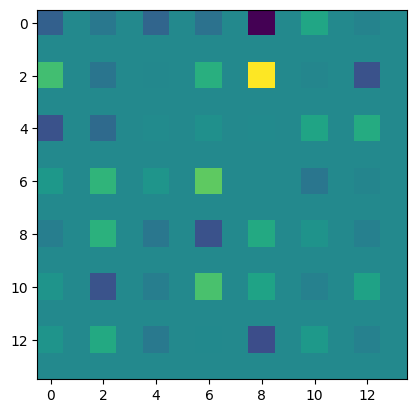

In [261]:
plt.imshow(insert_zeros(dJdZ, 2)[0, :, :, 0])

In [240]:
# Let's now try via conv_transpose
A_0 = tf.random.normal((32, 8, 8, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
#dJdZ = tf.random.normal((32, 6, 6, 16))  # (batch=32, height=8, width=8, channels_out=16)
expected_Z = tf.random.normal((32, 6, 6, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=[1, 1], padding='VALID')
  # compute mse loss against expected_Z
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

# prove that a normal looking conv2d_transpose works
# emulates dJdA_0 - backprop w.r.t. input
fun = tf.nn.conv2d_transpose(
    input=tf.random.normal((5, 6, 6, 16)),
    filters=tf.random.normal((3, 3, 5, 16)),
    output_shape=(5, 8, 8, 5),  # want (5, 3, 3, 16) or (3, 3, 5, 16)
    strides=[1, 1],
    padding='VALID')
print(f"fun: {fun.shape}")
print()

fun = tf.nn.conv2d_transpose(
    input=tf.random.normal((5, 8, 9, 32)),
    filters=tf.random.normal((3, 4, 16, 32)),
    output_shape=(5, 10, 12, 16),  # want (5, 3, 3, 16) or (3, 3, 5, 16)
    strides=[1, 1],
    padding='VALID')
print(f"fun: {fun.shape}")
print()

# emulating dJdA_0 - backprop w.r.t. input (simple VALID padding, and 1x1 strides)
dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(A_0),       # (5, 8, 8, 32) <- (32, 8, 8, 5)
    filters=tf_NHWC_to_HWIO(dJdZ),    # (6, 6, 32, 16) <- (32, 6, 6, 16)
    strides=[1, 1],
    padding='VALID')                  # (5, 3, 3, 16)   -> (3, 3, 5, 16)
print(f"input={tf_NHWC_to_CHWN(A_0).shape}, filters={tf_NHWC_to_HWIO(dJdZ).shape}")
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")

true: dJdZ: (32, 6, 6, 16), dJdW: (3, 3, 5, 16)
fun: (5, 8, 8, 5)

fun: (5, 10, 12, 16)

input=(5, 8, 8, 32), filters=(6, 6, 32, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-8.940697e-08 -7.450581e-09  0.000000e+00  7.450581e-09  8.940697e-08], same: True


## Appendix: Understanding the model graph structure

In [ ]:
model.summary()


In [ ]:
def find_layer_by_node(model, node, return_type='layer'):
  """
  :return_type: one of 'layer', 'index'
  """
  if return_type not in ['layer', 'index']:
    raise ValueError(f"return_type must be one of 'layer', 'index', got: {return_type}")
  for l_idx, layer in enumerate(model.layers):
    if node in layer._inbound_nodes:
      return layer if return_type == 'layer' else l_idx
  return None

def find_inbound_layers(model, layer, return_type='layer'):
  """
  :return_type: one of 'layer', 'index'
  """
  layers = [find_layer_by_node(model, node, return_type) for inbound in layer._inbound_nodes for node in inbound.parent_nodes]
  return [node for node in layers if node != None]

def find_outbound_layers(model, layer, return_type='layer'):
  """
  :return_type: one of 'layer', 'index'
  """
  layers = [find_layer_by_node(model, node, return_type) for node in layer._outbound_nodes]
  return [node for node in layers if node != None]


for l_idx in range(len(model.layers)):
  layer = model.layers[l_idx]
  print(f"Reference layer #{l_idx}: {layer}")
  print(f"  Inbound: {find_inbound_layers(model, layer, 'index')} = {find_inbound_layers(model, layer)}")
  print(f"  Outbound: {find_outbound_layers(model, layer, 'index')} = {find_outbound_layers(model, layer)}")




In [ ]:
model.layers[0]._inbound_nodes[0].parent_nodes

In [ ]:
model.layers[1].summary()

In [ ]:
for l_idx, layer in enumerate(model.layers):
  print(f"layer #{l_idx}: {layer.name}")
  print(f"  ")

In [ ]:
model.layers[1]

In [ ]:
model.layers[1]._inbound_nodes

In [ ]:
model.layers[1]._inbound_nodes[0].parent_nodes

In [ ]:
model.layers[1]._inbound_nodes[0].parent_nodes[0].parent_nodes

In [ ]:
model.layers[1]._outbound_nodes

In [ ]:
model.layers[1]._outbound_nodes[0].outputs

In [ ]:
model.layers[1]._outbound_nodes[0].layer